<a href="https://colab.research.google.com/github/n8mcdunna/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/assignment_214_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv', parse_dates= ['Date'], index_col= 'Date')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
# Convert great ratings to binary
#df['Great'].replace({'False': 0, 'True': 1}, inplace= True)
df['Great'] = df['Great'].astype('int')

In [8]:
print('shape:', df.shape)
df.select_dtypes('object').nunique()

shape: (421, 58)


Burrito          5
Chips            4
Unreliable       1
NonSD            2
Beef             2
Pico             2
Guac             2
Cheese           2
Fries            2
Sour cream       2
Pork             2
Chicken          2
Shrimp           2
Fish             2
Rice             2
Beans            2
Lettuce          2
Tomato           2
Bell peper       2
Carrots          1
Cabbage          2
Sauce            2
Salsa.1          2
Cilantro         2
Onion            2
Taquito          2
Pineapple        2
Ham              1
Chile relleno    1
Nopales          1
Lobster          1
Egg              1
Mushroom         1
Bacon            1
Sushi            1
Avocado          1
Corn             2
Zucchini         1
dtype: int64

In [9]:
df.isnull().sum()

Burrito             0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple         414
Ham       

In [10]:
# Dropping columns that have more than 50 NaNs
for column in df.columns:
  if df[column].isnull().sum() > 50:
    df.drop(columns= column, inplace= True)
df.head()

,Burrito,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
Date,,,,,,,,,,,,,
2016-01-18,California,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0
2016-01-24,California,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0
2016-01-24,Carnitas,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0
2016-01-24,Asada,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0
2016-01-27,California,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,1


# Split data into train, validate, and test sets

In [11]:
target = 'Great'
y = df[target]
X = df.drop(columns= target)

In [12]:
test_cutoff = '2018-01-01'
val_cutoff = '2017-01-01'
mask = df.index >= '2018-01-01'
test = df[mask]
val = df[(df.index >= val_cutoff) & (df.index < test_cutoff)]
train = df[df.index < val_cutoff]

In [13]:
X_test = test.drop(columns= target)
X_val = val.drop(columns= target)
X_train = train.drop(columns= target)

y_test = test[target]
y_val = val[target]
y_train = train[target]

# Baseline using train data (2016 and earlier)

In [14]:
baseline = train['Great'].value_counts(normalize= True).max()

In [15]:
print('Baseline accuracy:', round(baseline*100, 5),'%')

Baseline accuracy: 59.0604 %


# Build logistic regression model

In [16]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
model = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', ran

# Check logistic regression model accuracy

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print('Training accuracy:   ', model.score(X_train, y_train))
print('Validation accuracy: ', model.score(X_val, y_val))

Training accuracy:    0.889261744966443
Validation accuracy:  0.8235294117647058


In [20]:

# 0.889
# 0.835

In [26]:
print('Testing accuracy: ', model.score(X_test, y_test))

Testing accuracy:  0.7631578947368421


# Plotting coefficients

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
coefficients = model.named_steps['logisticregression'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()

In [24]:
coefficients = pd.Series(coefficients[0]).sort_values()

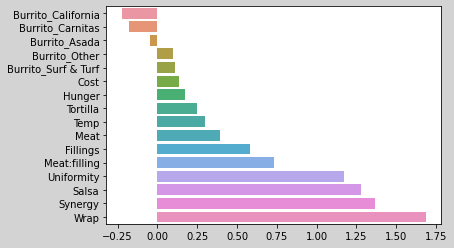

In [25]:
fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')

#plt.barh(features, coefficients)

sns.barplot(x= coefficients, y = features);
plt.show()

In [32]:
model.named_steps['logisticregression'].predict_proba('2018-01-18')

ValueError: ignored